# Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data

### Notebook developed to implement the fault detection system described in the paper *Fault Detection in Wastewater Treatment Plants: Application of Autoencoders with Streaming Data*

### Data obtained with the BSM2 simulator.

In [ ]:
# Load libraries needed by the project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timezone
import statsmodels.api as sm
import scipy.stats as st
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.models import load_model
%matplotlib inline

In [ ]:
# Load dataset
df1 = pd.read_csv('/content/drive/MyDrive/Autoencoder/datasets/sensor_ox_bsm2.csv', sep=';')

In [ ]:
df1.head()

,time,value
0,0.000000,0.244862
1,0.010417,2.766354
2,0.020833,1.801208
3,0.031250,2.127110
4,0.041667,1.963473


In [ ]:
# Create dataframe with dates and values of DO levels.
df = pd.DataFrame()
df['Date'] = df1.time
df['value'] = df1.value

In [ ]:
# Adjust stuck anomaly value
# Check indices of anomalous samples
df1.loc[df1['time'] == 90]

# Adjust Drift Values
index1 = df.index[df['Date']>=40].tolist()
index2 = df.index[df['Date']<=43].tolist()
max(index2)
min(index1)
for i in range(8640,9120):
  df.loc[i,'value'] = df.loc[i,'value']+0.5 

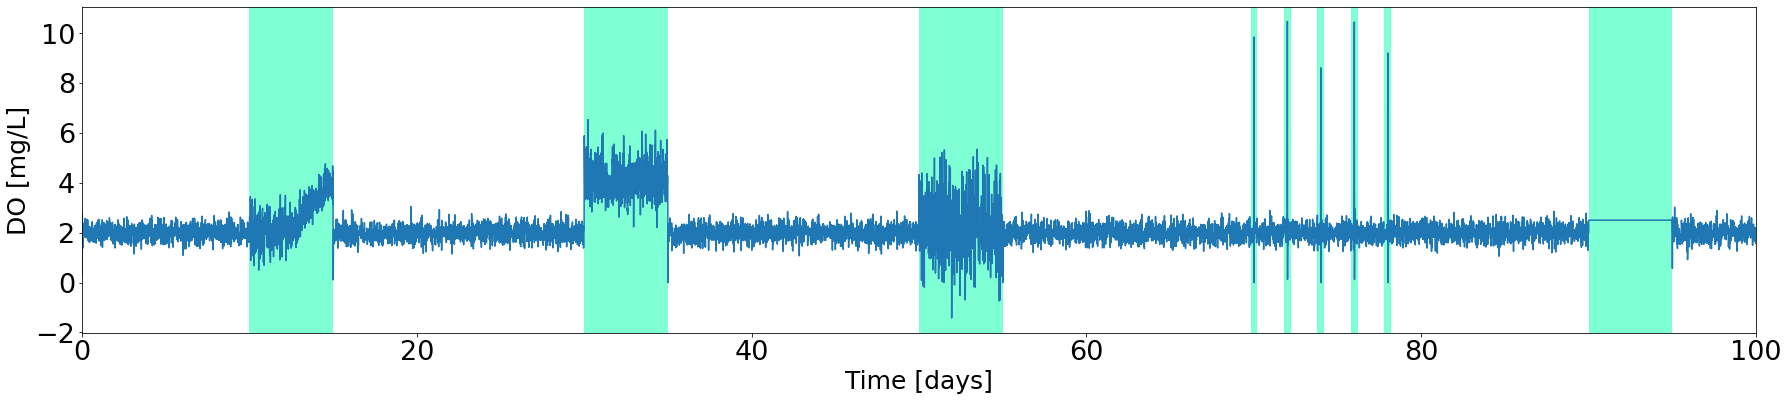

In [ ]:
# Graph of the time series and implemented failures 
plt.figure(figsize = (30, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="Date", y="value", data=df[0:10000])
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.xlim(0,100)

p.axvspan(10, 15, facecolor='aquamarine')
p.axvspan(30, 35, facecolor='aquamarine')
p.axvspan(50, 55, facecolor='aquamarine')
#p.axvspan(70, 78, facecolor='aquamarine')
p.axvspan(69.8, 70.2, facecolor='aquamarine')
p.axvspan(71.8, 72.2, facecolor='aquamarine')
p.axvspan(73.8, 74.2, facecolor='aquamarine')
p.axvspan(75.8, 76.2, facecolor='aquamarine')
p.axvspan(77.8, 78.2, facecolor='aquamarine')




p.axvspan(90, 95, facecolor='aquamarine')


#plt.savefig('/content/drive/MyDrive/Autoencoder/falhas_caso1_25_07.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Faults inserted in the BSM2 simulator.

### Drift: 
Start: day 10 (index 960)

End: day 15 (index 1440)

Total anomalous samples: 480

### Bias:
Start: day 30 (index 2880)

End: day 35 (index 3360)

Total anomalous samples: 480

### Precision degradation:
Start: day 50 (index 4800)

End: day 55 (index 5280)

Total anomalous samples: 480

### Spike:
Peaks with a duration of 15 minutes (real time), in the simulation it is equal to 0.0104 seconds.

Peaks in days: 70 (index 6720), 72 (index 6912), 74 (index 7104), 76 (index 7296), 78 (index 7448).



In [ ]:
# Check indices of anomalous samples
df1.loc[df1['time'] == 78]

,time,value
7488,78.0,9.196938


## Data processing

### Split dataset into training and testing sets

In [ ]:
df1_treino = df.iloc[9500:15361,:]
df1_teste = df.iloc[0:10000,:]

(0.0, 100.0)

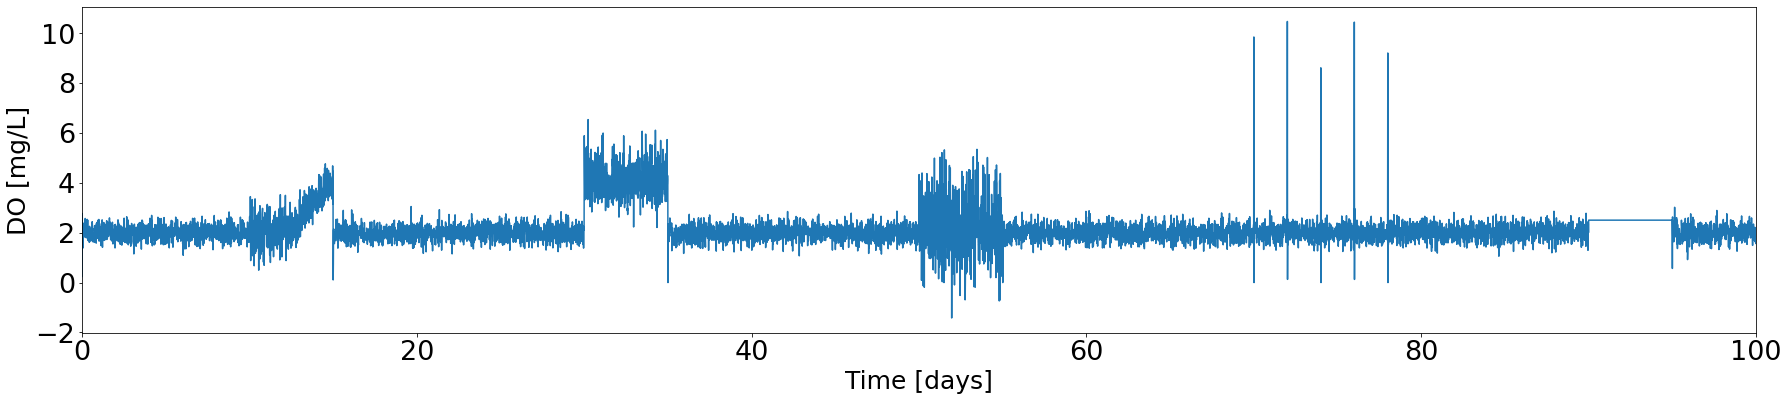

In [ ]:
plt.figure(figsize = (30, 6))
#p = sns.lineplot(x="time", y="value", data=df1[0:8640])
p = sns.lineplot(x="Date", y="value", data=df1_teste)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.xlim(0,100)

In [ ]:
df1_treino.to_csv('df_treino_bsm2.csv')

In [ ]:
# Using time as an index
df1_treino = pd.read_csv('df_treino_bsm2.csv', parse_dates=True, index_col="Date")

In [ ]:
# Delete column created with old indexes
df1_treino = df1_treino.drop(columns=['Unnamed: 0'])

In [ ]:
df1_treino.head()

,value
Date,
98.958333,2.268076
98.968750,2.123805
98.979167,1.889731
98.989583,2.185977
99.000000,2.301383


(array([0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25]),
 <a list of 11 Text major ticklabel objects>)

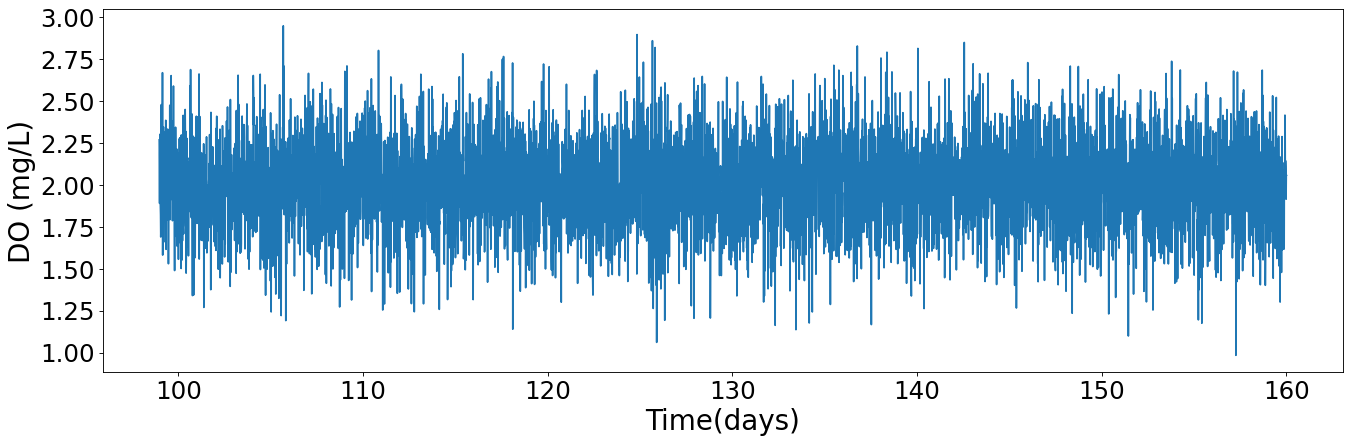

In [ ]:
# Graph
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

#plt.figure(figsize = (15, 6))
p = sns.lineplot(x="Date", y="value", data=df1_treino)

plt.xlabel('Time(days)', fontsize=25)
plt.ylabel('DO (mg/L)', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#plt.savefig('/content/drive/MyDrive/Autoencoder/DO_normal_25_05.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Implementing Autoencoders

In [ ]:
# Normalizing the datas
training1_mean = df1_treino.mean()
training1_std = df1_treino.std()
df1_training_value = (df1_treino - training1_mean) / training1_std
print("Number of training samples:", len(df1_training_value))    

Number of training samples: 5861


In [ ]:
df1_training_value.head()

,value
time,
98.958333,0.983084
98.968750,0.445717
98.979167,-0.426139
98.989583,0.677289
99.000000,1.107142


In [ ]:
# Create the window that will go through the sequence
TIME_STEPS = 96

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df1_training_value.values) 

In [ ]:
x_train.shape

(5765, 96, 1)

## Creating the model

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 32)            256       
                                                                 
 dropout_2 (Dropout)         (None, 48, 32)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 24, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 48, 16)           1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 48, 16)            0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 96, 32)           3616      
 ranspose)                                            

In [ ]:
#Training the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

In [ ]:
model.save("/content/drive/MyDrive/Autoencoder/modelos/model_autoencoder_conv1.h5")

In [ ]:
model = load_model('/content/drive/MyDrive/Autoencoder/modelos/model_autoencoder_conv1.h5')

Reconstruction error threshold:  0.22230595703095143


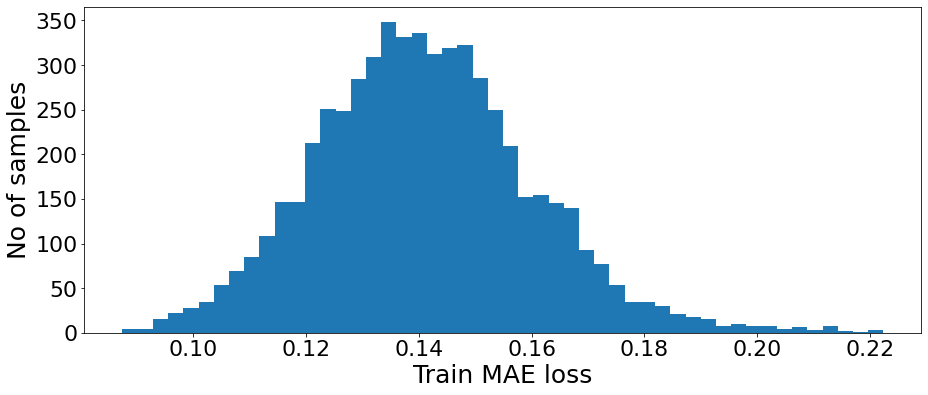

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
plt.figure(figsize = (15, 6))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss", fontsize=25)
plt.ylabel("No of samples", fontsize=25)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


#plt.savefig('/content/drive/MyDrive/Autoencoder/fig_BSM2_caso_1/reconstucao_erro_conv1.pdf', dpi=500, format='pdf', bbox_inches='tight')
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.show()

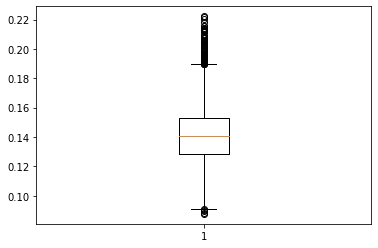

In [ ]:
# Alternative to determine the threshold: boxplot

bp = plt.boxplot(train_mae_loss)

In [ ]:
#threshold = 0.22393348

## Tests

In [ ]:
df1_teste.to_csv('df_teste_bsm2.csv')
# Using time as index
df1_teste = pd.read_csv('df_teste_bsm2.csv', parse_dates=True, index_col="Date")
# Delete column created with old indexes
df1_teste = df1_teste.drop(columns=['Unnamed: 0'])

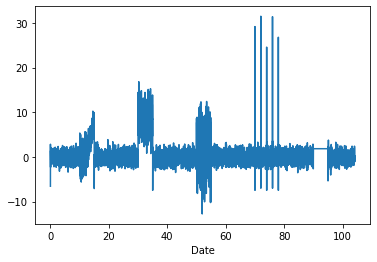

Test input shape:  (9904, 96, 1)


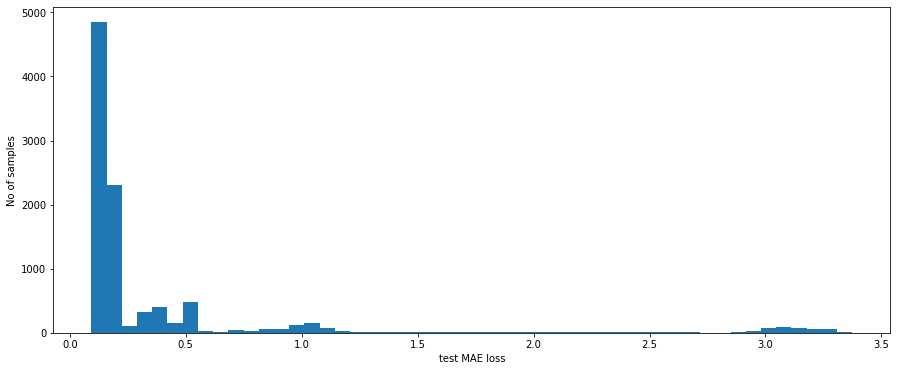

Number of anomaly samples:  2753
Indices of anomaly samples:  (array([ 882,  884,  886, ..., 9118, 9119, 9144]),)


In [ ]:

df_test_value = (df1_teste - training1_mean) / training1_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
plt.figure(figsize = (15, 6))
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [ ]:
# Anomalous values
df_subset = df1_teste.iloc[anomalous_data_indices] 

In [ ]:
df1_teste.head()

,value
time,
0.000000,0.244862
0.010417,2.766354
0.020833,1.801208
0.031250,2.127110
0.041667,1.963473


In [ ]:
# Create column with indexes to facilitate plots
df_subset['id2'] = df_subset.index
df1_teste['id1'] = df1_teste.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df1_teste

,value,id1
time,,
0.000000,0.244862,0.000000
0.010417,2.766354,0.010417
0.020833,1.801208,0.020833
0.031250,2.127110,0.031250
0.041667,1.963473,0.041667
...,...,...
104.114583,2.079441,104.114583
104.125000,1.725304,104.125000
104.135417,2.006942,104.135417


## Results

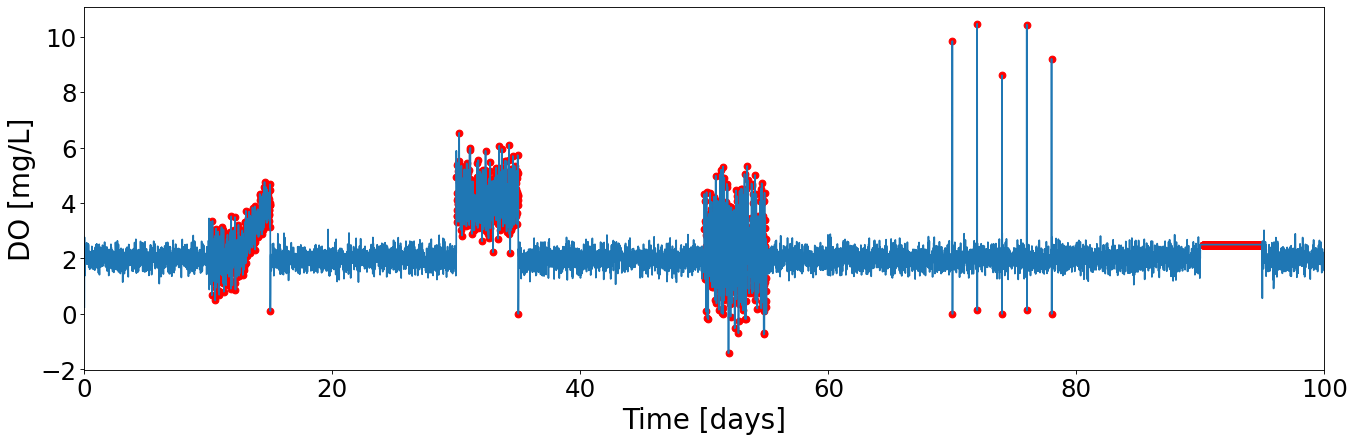

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(0,100)


plt.scatter(df_subset.id2,df_subset.value, color="r")
plt.plot(df1_teste.id1, df1_teste.value)

#plt.savefig('/content/drive/MyDrive/Autoencoder/resultado_total_conv1.pdf', dpi=500, format='pdf', bbox_inches='tight')

## Graph with individual results

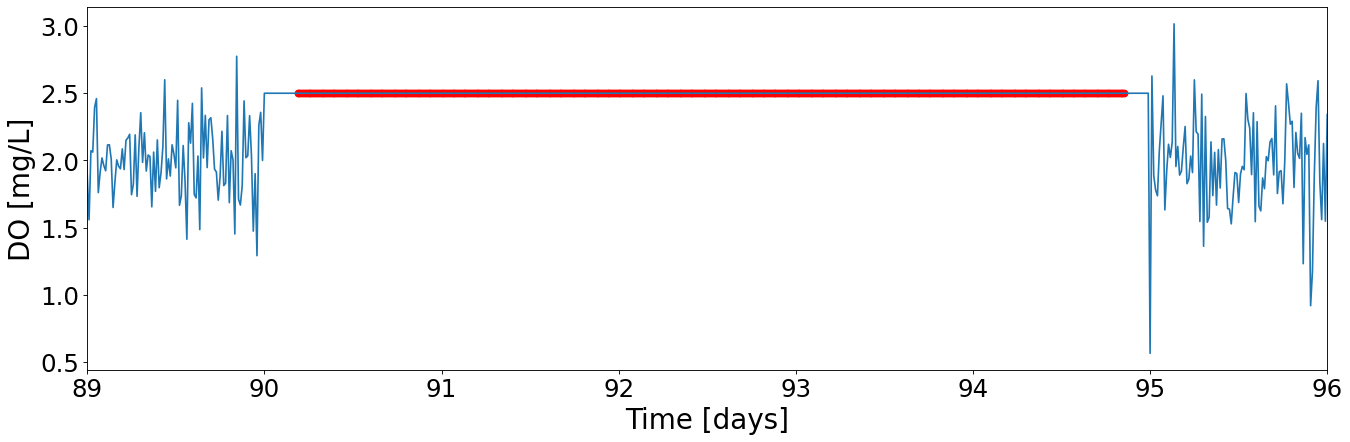

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[1424:2700],df_subset.value.iloc[1424:2700], color="r")
plt.plot(df1_teste.id1.iloc[8540:9220], df1_teste.value.iloc[8540:9220])
plt.xlim(89,96)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_1/resultado_stuck1_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures: Stuck

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 80].head(3) # 90.187500	

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 10].head(1) #90.0

# Do the math for the fraction that equals 15 min.
((90.187500 - 90.0)*15)/0.010416666666666666 # 270.0

270.0

In [ ]:
# Count number of anomalies: STUCK
cont = 0
for i in df_subset['id2']:
  if i >= 85 and i <= 100:
    cont = cont+1
print('Nº de anomalias para a falha Stuck: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 90 and i <= 95:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Stuck: ',cont2)


Nº de anomalias para a falha Stuck:  0
Nº de amostras totais para a falha Stuck:  481


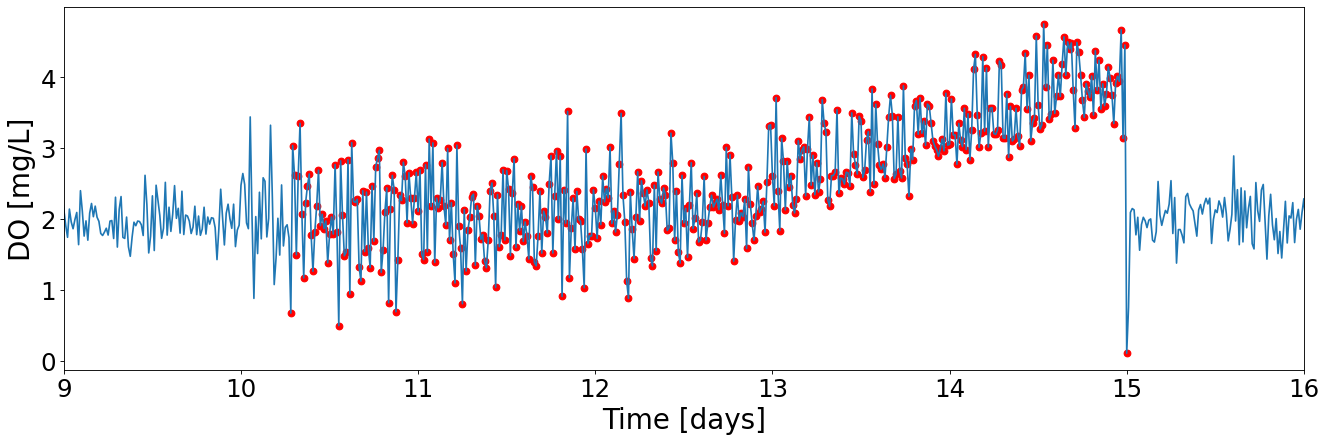

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[0:454],df_subset.value.iloc[0:454], color="r")
plt.plot(df1_teste.id1.iloc[800:1600], df1_teste.value.iloc[800:1600])
plt.xlim(9,16)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_1/resultado_drift1_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures: drift

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 10].head(1) # 10.28125

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 10].head(1) #10.0

#  Do the math for the fraction that equals 15 min.
((10.28125 - 10.0)*15)/0.010416666666666666 # 405.0

405.0

In [ ]:
# Count number of anomalies: DRIFT
cont = 0
for i in df_subset['id2']:
  if i >= 10 and i <= 15:
    cont = cont+1
print('Nº de anomalias para a falha Drift: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 10 and i <= 15:
    cont2 = cont2 + 1


print('Nº de amostras totais para a falha Drift: ',cont2)

Nº de anomalias para a falha Drift:  454
Nº de amostras totais para a falha Drift:  481


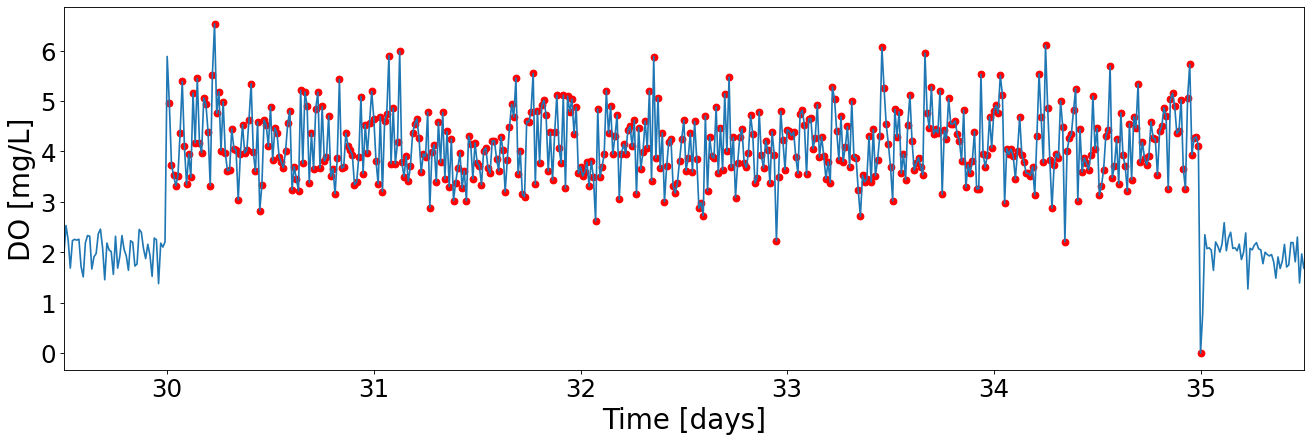

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[454:934],df_subset.value.iloc[454:934], color="r")
plt.plot(df1_teste.id1.iloc[2800:3450], df1_teste.value.iloc[2800:3450])
plt.xlim(29.5,35.5)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_1/resultado_bias1_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
#df_subset.loc[df_subset['id2'] >= 30].head(1) # 30.010417

# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 30].head(1) #30.0

# Do the math for the fraction that equals 15 min.
((30.010417 - 30.000000)*15)/0.010416666666666666 # 15.000480000000493

15.000480000000493

In [ ]:
# Count number of anomalies: BIAS
cont = 0
for i in df_subset['id2']:
  if i >= 30 and i <= 35:
    cont = cont+1

print('Nº de anomalias para a falha Bias: ',cont)


cont2 = 0
for i in df1_teste['id1']:
  if i >= 30 and i <= 35:
    cont2 = cont2 + 1


print('Nº de amostras totais para a falha Bias: ',cont2)



Nº de anomalias para a falha Bias:  480
Nº de amostras totais para a falha Bias:  481


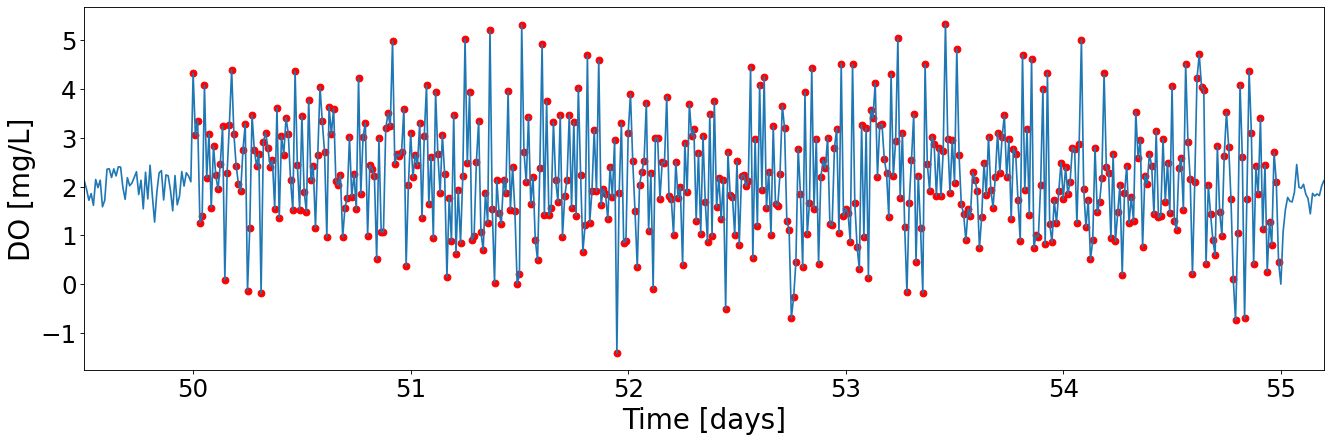

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[934:1414],df_subset.value.iloc[934:1414], color="r")
plt.plot(df1_teste.id1.iloc[4750:5310], df1_teste.value.iloc[4750:5310])
plt.xlim(49.5,55.2)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_1/resultado_PD1_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Calculation of delay in detection of failures

# Identify the first failure detection time
df_subset.loc[df_subset['id2'] >= 50].head(1) # 50.052083


# Identify the time of the first failure sample
#df1_teste.loc[df1_teste['id1'] >= 50].head(1) #30.0

# Do the math for the fraction that equals 15 min.
((50.0 - 50.0)*15)/0.010416666666666666 # 0.0

0.0

In [ ]:
# Count number of anomalies: DEGRADATION
cont = 0
for i in df_subset['id2']:
  if i >= 50 and i <= 55:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)



cont2 = 0
for i in df1_teste['id1']:
  if i >= 50 and i <= 55:
    cont2 = cont2 + 1
print('Nº de amostras totais para a falha Degradation: ',cont2)

Nº de anomalias para a falha Degradation:  480
Nº de amostras totais para a falha Degradation:  481


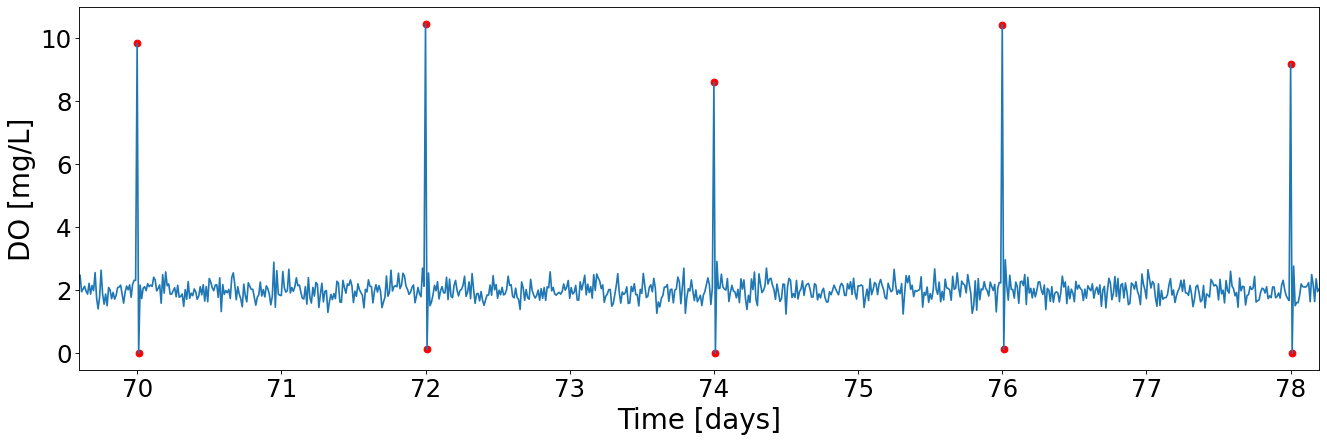

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)

plt.scatter(df_subset.id2.iloc[1414:1424],df_subset.value.iloc[1414:1424], color="r")
plt.plot(df1_teste.id1.iloc[6680:7550], df1_teste.value.iloc[6680:7550])
plt.xlim(69.6,78.2)
plt.xlabel('Time [days]', fontsize=25)
plt.ylabel('DO [mg/L]', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('/content/drive/MyDrive/Autoencoder/figura_conv_1/resultado_spike1_conv.pdf', dpi=500, format='pdf', bbox_inches='tight')

In [ ]:
# Count number of anomalies: SPIKE
cont = 0
for i in df_subset['id2']:
  if i >= 70 and i <= 79:
    cont = cont + 1
print('Nº de anomalias para a falha Degradation: ',cont)

Nº de anomalias para a falha Degradation:  10
